In [1]:
#!for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from data_processing import dataset
from models import model
from utils import tools
from plots import plots, edge_detection_plots

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
#np.set_printoptions(threshold=sys.maxsize)

2022-12-12 22:01:41.231691: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 22:01:41.322507: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-12 22:01:41.343046: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-12 22:01:41.740238: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
config_directory = 'edge_detection_with_prior'

config_path = os.path.join(os.getcwd(), 'configs', config_directory)
Model = model.Model(config_path)
DataProcessing = dataset.DataProcessing(input_shape_img=Model.cfg["INPUT_SHAPE_IMG"],
                                        input_shape_mask=Model.cfg["INPUT_SHAPE_MASK"],
                                        output_shape=Model.cfg["OUTPUT_SHAPE"],
                                        config_path=config_path)
tools.parser(Model.cfg, DataProcessing.cfg)
Model.load_data(DataProcessing.cfg["NAME"])
DataProcessing.path_definitions()

2022-12-12 22:01:42.846510: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 22:01:42.850687: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 22:01:42.850801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 22:01:42.851174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

# Load Dataset, Preprocess Images and Dataset

The TRAIN DS contains 1332 images.
The TEST DS contains 300 images.
The IMG_ONLY DS contains 20 images.


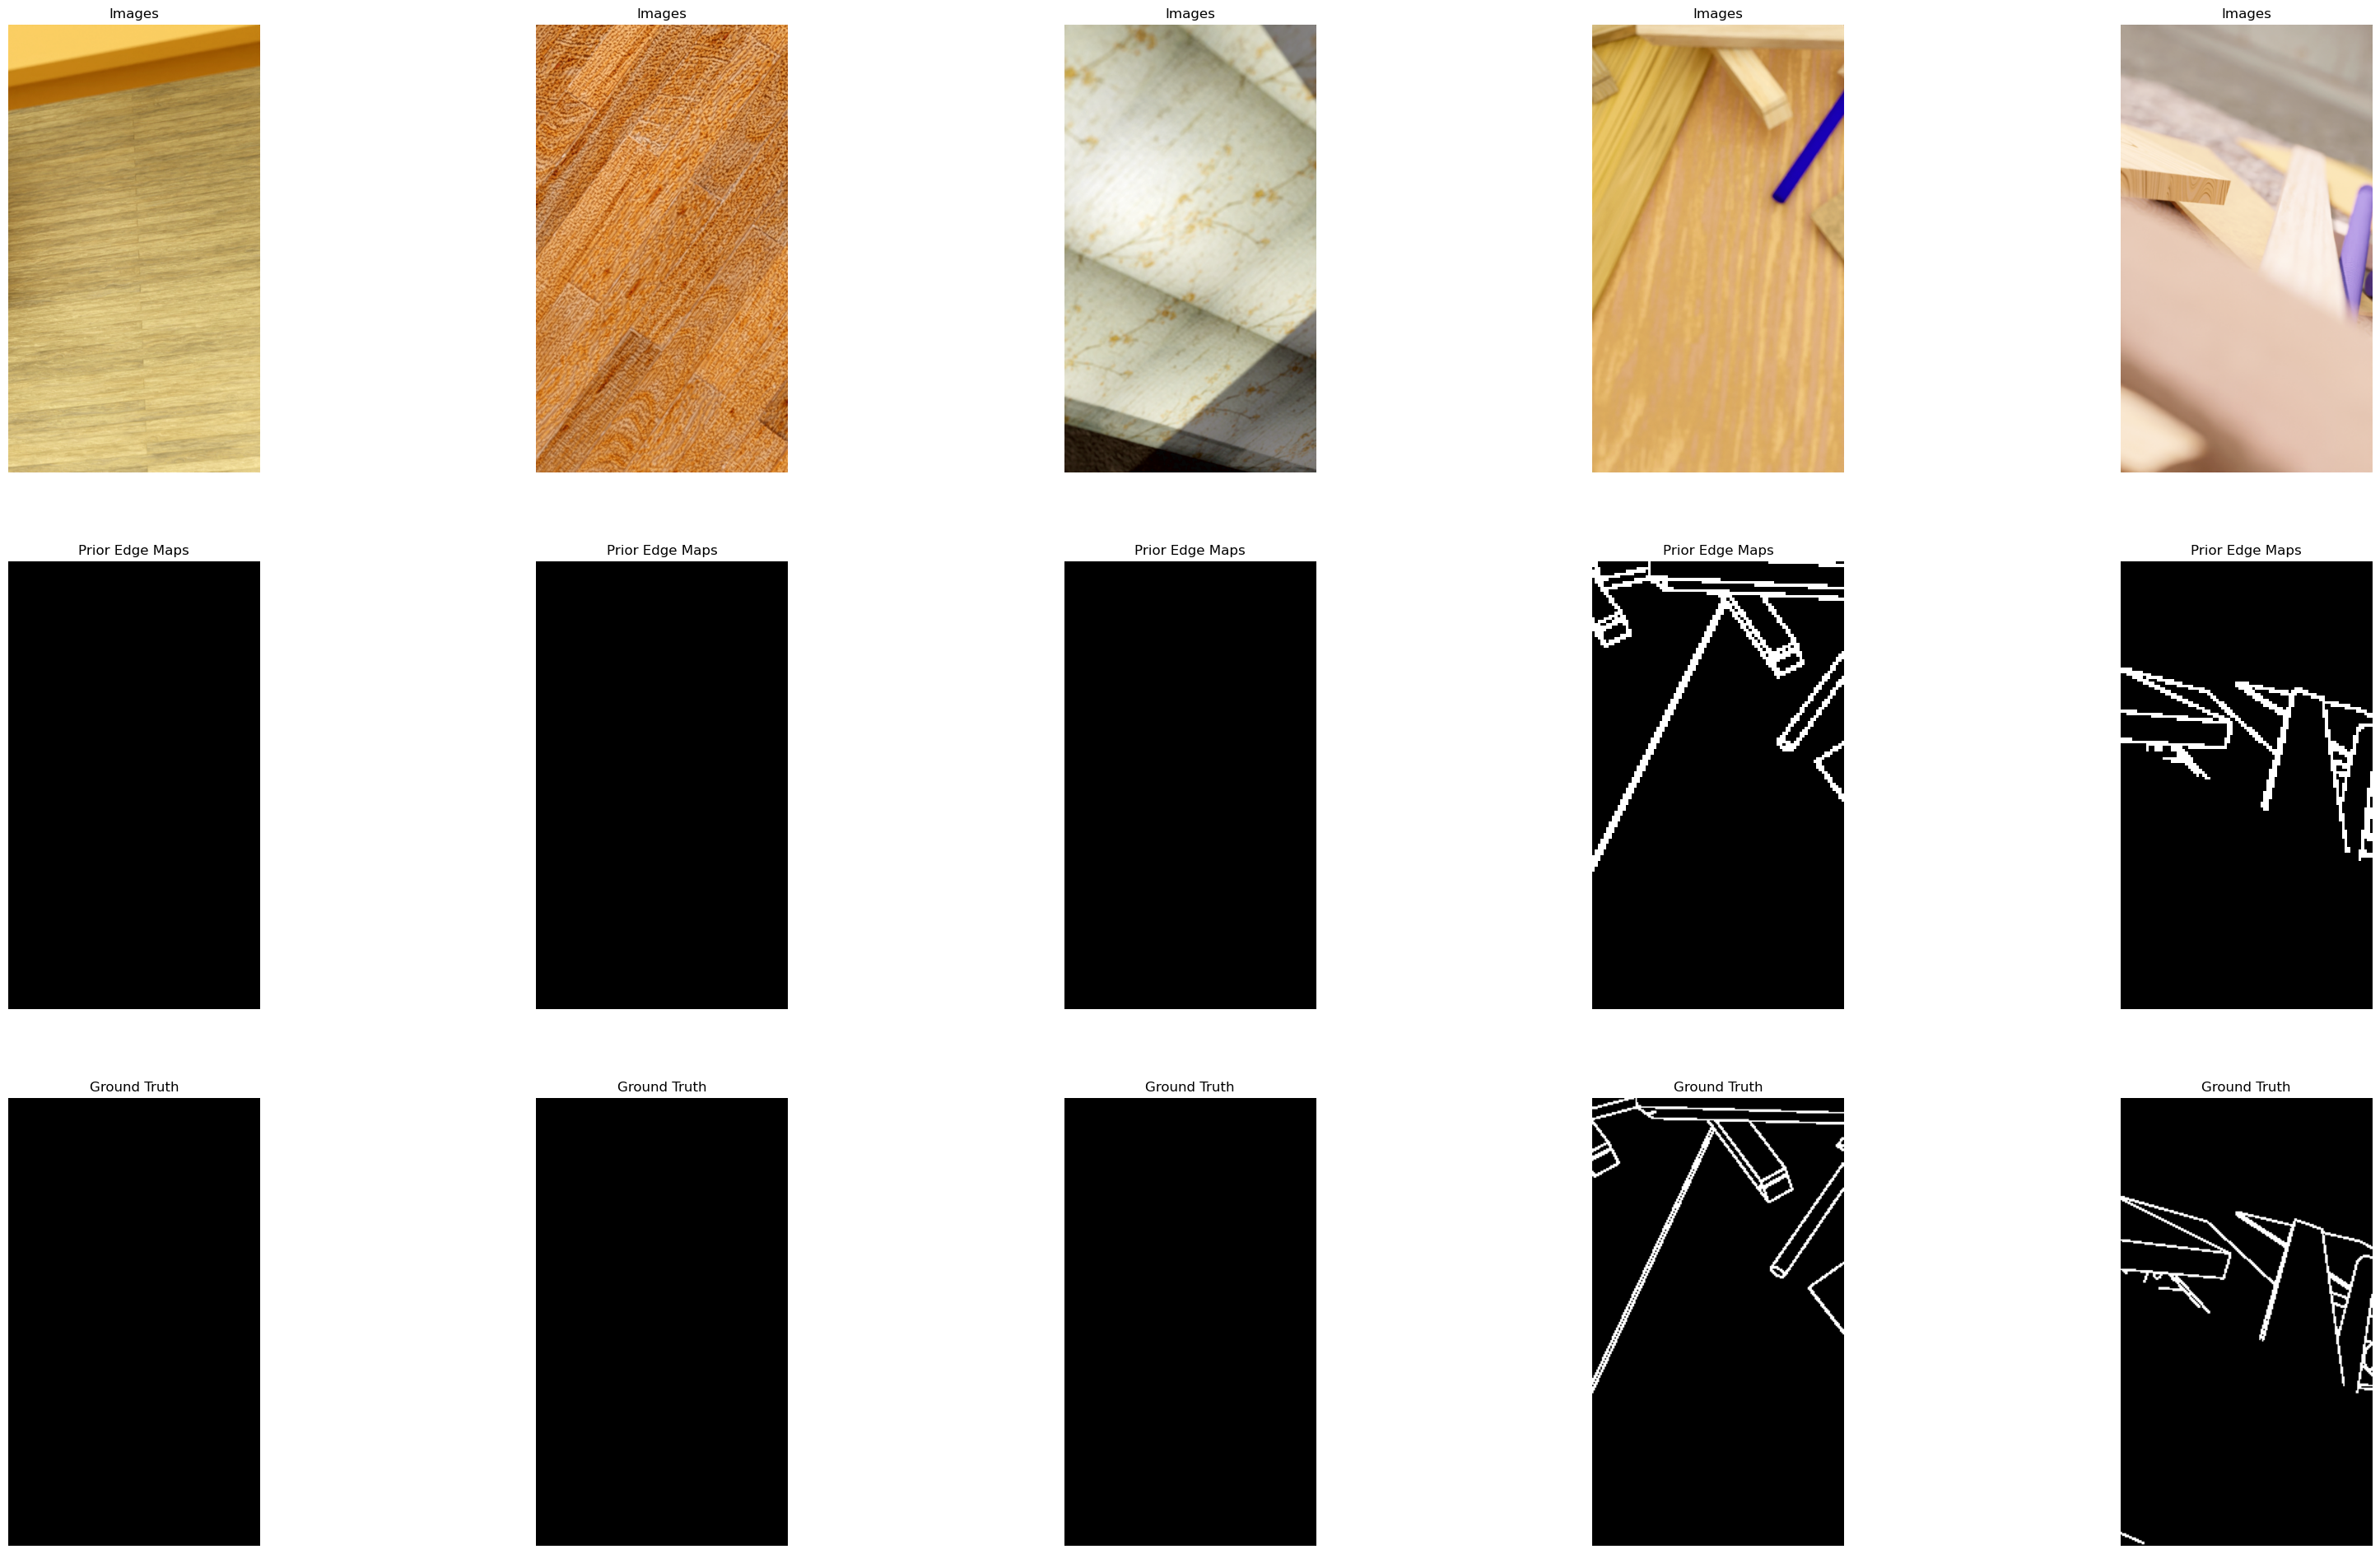

In [3]:
if Model.train_model:
    train_ds, img_count_train = DataProcessing.load_dataset(DataProcessing.key.train)
test_ds, img_count_test = DataProcessing.load_dataset(DataProcessing.key.test)

img_only_ds, img_count_img_only_ds = DataProcessing.load_dataset(DataProcessing.key.img_only)

if Model.train_model:
    for inp, out in train_ds.take(1):
        edge_detection_plots.plot_edges(images=inp['in_img'], labels=out['out_edge'],
                                        prior = inp['in_edge'],
                                        batch_size=DataProcessing.cfg['TEST']['BATCH_SIZE'],
                                        num_classes=DataProcessing.num_classes['edge'])

# Define, Compile and Train Model

In [4]:
if Model.train_model:
    model = Model.get_neural_network_model(DataProcessing.num_classes['edge'])
    # model.summary()

    lr = Model.get_lr(img_count_train, DataProcessing.cfg['TRAIN']['BATCH_SIZE'])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss=Model.get_loss_function(),
                  metrics=Model.get_metrics(DataProcessing.num_classes['edge']))

    history = model.fit(train_ds, epochs=Model.cfg["EPOCHS"], validation_data=train_ds,
                        callbacks=Model.get_callbacks(), verbose=1)

model = Model.get_best_model_from_checkpoints()

(640, 360, 3)
Epoch 1/120


2022-12-12 22:01:54.970829: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-12-12 22:01:55.724937: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


267/267 [==============================] - 59s 204ms/step - loss: 763.7034 - accuracy: 0.9435 - accuracy_1: 0.9435 - f1: 0.4540 - precision: 0.5207 - recall: 0.4103 - f1_1: 0.4540 - precision_1: 0.5207 - recall_1: 0.4103 - val_loss: 914.8282 - val_accuracy: 0.9514 - val_accuracy_1: 0.9514 - val_f1: 0.6362 - val_precision: 0.5300 - val_recall: 0.7956 - val_f1_1: 0.6362 - val_precision_1: 0.5300 - val_recall_1: 0.7956
Epoch 2/120
267/267 [==============================] - 54s 204ms/step - loss: 514.8314 - accuracy: 0.9735 - accuracy_1: 0.9735 - f1: 0.7431 - precision: 0.7921 - recall: 0.6999 - f1_1: 0.7431 - precision_1: 0.7921 - recall_1: 0.6999 - val_loss: 684.6132 - val_accuracy: 0.9652 - val_accuracy_1: 0.9652 - val_f1: 0.7143 - val_precision: 0.6365 - val_recall: 0.8138 - val_f1_1: 0.7143 - val_precision_1: 0.6365 - val_recall_1: 0.8138
Epoch 3/120
267/267 [==============================] - 54s 203ms/step - loss: 483.8533 - accuracy: 0.9745 - accuracy_1: 0.9745 - f1: 0.7515 - precis

INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_with_prior/CKPT/ckpt-loss=448.21-epoch=10.00-f1=0.8011/assets


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_with_prior/CKPT/ckpt-loss=448.21-epoch=10.00-f1=0.8011/assets


267/267 [==============================] - 62s 230ms/step - loss: 410.6225 - accuracy: 0.9788 - accuracy_1: 0.9788 - f1: 0.7933 - precision: 0.8355 - recall: 0.7554 - f1_1: 0.7933 - precision_1: 0.8355 - recall_1: 0.7554 - val_loss: 448.2117 - val_accuracy: 0.9773 - val_accuracy_1: 0.9773 - val_f1: 0.8011 - val_precision: 0.7531 - val_recall: 0.8555 - val_f1_1: 0.8011 - val_precision_1: 0.7531 - val_recall_1: 0.8555
Epoch 11/120
267/267 [==============================] - 54s 201ms/step - loss: 409.3541 - accuracy: 0.9791 - accuracy_1: 0.9791 - f1: 0.8028 - precision: 0.8362 - recall: 0.7720 - f1_1: 0.8028 - precision_1: 0.8362 - recall_1: 0.7720 - val_loss: 391.1518 - val_accuracy: 0.9803 - val_accuracy_1: 0.9803 - val_f1: 0.8042 - val_precision: 0.8570 - val_recall: 0.7575 - val_f1_1: 0.8042 - val_precision_1: 0.8570 - val_recall_1: 0.7575
Epoch 12/120
267/267 [==============================] - 54s 202ms/step - loss: 399.2471 - accuracy: 0.9802 - accuracy_1: 0.9802 - f1: 0.8067 - prec

INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_with_prior/CKPT/ckpt-loss=415.66-epoch=20.00-f1=0.7826/assets


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_with_prior/CKPT/ckpt-loss=415.66-epoch=20.00-f1=0.7826/assets


267/267 [==============================] - 61s 230ms/step - loss: 380.0024 - accuracy: 0.9809 - accuracy_1: 0.9809 - f1: 0.8158 - precision: 0.8529 - recall: 0.7819 - f1_1: 0.8158 - precision_1: 0.8529 - recall_1: 0.7819 - val_loss: 415.6570 - val_accuracy: 0.9796 - val_accuracy_1: 0.9796 - val_f1: 0.7826 - val_precision: 0.9098 - val_recall: 0.6866 - val_f1_1: 0.7826 - val_precision_1: 0.9098 - val_recall_1: 0.6866
Epoch 21/120
267/267 [==============================] - 54s 202ms/step - loss: 377.4707 - accuracy: 0.9799 - accuracy_1: 0.9799 - f1: 0.8120 - precision: 0.8517 - recall: 0.7759 - f1_1: 0.8120 - precision_1: 0.8517 - recall_1: 0.7759 - val_loss: 375.3771 - val_accuracy: 0.9814 - val_accuracy_1: 0.9814 - val_f1: 0.8171 - val_precision: 0.8602 - val_recall: 0.7782 - val_f1_1: 0.8171 - val_precision_1: 0.8602 - val_recall_1: 0.7782
Epoch 22/120
267/267 [==============================] - 54s 203ms/step - loss: 375.9362 - accuracy: 0.9800 - accuracy_1: 0.9800 - f1: 0.8131 - prec

INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_with_prior/CKPT/ckpt-loss=374.13-epoch=30.00-f1=0.8241/assets


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_with_prior/CKPT/ckpt-loss=374.13-epoch=30.00-f1=0.8241/assets


267/267 [==============================] - 62s 234ms/step - loss: 362.2026 - accuracy: 0.9823 - accuracy_1: 0.9823 - f1: 0.8219 - precision: 0.8578 - recall: 0.7889 - f1_1: 0.8219 - precision_1: 0.8578 - recall_1: 0.7889 - val_loss: 374.1255 - val_accuracy: 0.9818 - val_accuracy_1: 0.9818 - val_f1: 0.8241 - val_precision: 0.8536 - val_recall: 0.7966 - val_f1_1: 0.8241 - val_precision_1: 0.8536 - val_recall_1: 0.7966
Epoch 31/120
267/267 [==============================] - 54s 202ms/step - loss: 359.6402 - accuracy: 0.9820 - accuracy_1: 0.9820 - f1: 0.8220 - precision: 0.8591 - recall: 0.7881 - f1_1: 0.8220 - precision_1: 0.8591 - recall_1: 0.7881 - val_loss: 360.7971 - val_accuracy: 0.9819 - val_accuracy_1: 0.9819 - val_f1: 0.8256 - val_precision: 0.8501 - val_recall: 0.8025 - val_f1_1: 0.8256 - val_precision_1: 0.8501 - val_recall_1: 0.8025
Epoch 32/120
267/267 [==============================] - 54s 203ms/step - loss: 360.3238 - accuracy: 0.9812 - accuracy_1: 0.9812 - f1: 0.8221 - prec

INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_with_prior/CKPT/ckpt-loss=431.54-epoch=40.00-f1=0.7642/assets


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_with_prior/CKPT/ckpt-loss=431.54-epoch=40.00-f1=0.7642/assets


267/267 [==============================] - 66s 248ms/step - loss: 350.8643 - accuracy: 0.9819 - accuracy_1: 0.9819 - f1: 0.8267 - precision: 0.8616 - recall: 0.7946 - f1_1: 0.8267 - precision_1: 0.8616 - recall_1: 0.7946 - val_loss: 431.5445 - val_accuracy: 0.9786 - val_accuracy_1: 0.9786 - val_f1: 0.7642 - val_precision: 0.9302 - val_recall: 0.6485 - val_f1_1: 0.7642 - val_precision_1: 0.9302 - val_recall_1: 0.6485
Epoch 41/120
267/267 [==============================] - 58s 219ms/step - loss: 349.3614 - accuracy: 0.9823 - accuracy_1: 0.9823 - f1: 0.8253 - precision: 0.8606 - recall: 0.7929 - f1_1: 0.8253 - precision_1: 0.8606 - recall_1: 0.7929 - val_loss: 396.7481 - val_accuracy: 0.9804 - val_accuracy_1: 0.9804 - val_f1: 0.8265 - val_precision: 0.7832 - val_recall: 0.8749 - val_f1_1: 0.8265 - val_precision_1: 0.7832 - val_recall_1: 0.8749
Epoch 42/120
267/267 [==============================] - 61s 227ms/step - loss: 350.3502 - accuracy: 0.9820 - accuracy_1: 0.9820 - f1: 0.8265 - prec

INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_with_prior/CKPT/ckpt-loss=347.58-epoch=50.00-f1=0.8278/assets


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_with_prior/CKPT/ckpt-loss=347.58-epoch=50.00-f1=0.8278/assets


267/267 [==============================] - 68s 254ms/step - loss: 341.8617 - accuracy: 0.9831 - accuracy_1: 0.9831 - f1: 0.8277 - precision: 0.8622 - recall: 0.7959 - f1_1: 0.8277 - precision_1: 0.8622 - recall_1: 0.7959 - val_loss: 347.5767 - val_accuracy: 0.9827 - val_accuracy_1: 0.9827 - val_f1: 0.8278 - val_precision: 0.8816 - val_recall: 0.7802 - val_f1_1: 0.8278 - val_precision_1: 0.8816 - val_recall_1: 0.7802
Epoch 51/120
267/267 [==============================] - 57s 213ms/step - loss: 340.4365 - accuracy: 0.9829 - accuracy_1: 0.9829 - f1: 0.8311 - precision: 0.8630 - recall: 0.8015 - f1_1: 0.8311 - precision_1: 0.8630 - recall_1: 0.8015 - val_loss: 338.2540 - val_accuracy: 0.9829 - val_accuracy_1: 0.9829 - val_f1: 0.8289 - val_precision: 0.8887 - val_recall: 0.7767 - val_f1_1: 0.8289 - val_precision_1: 0.8887 - val_recall_1: 0.7767
Epoch 52/120
267/267 [==============================] - 56s 210ms/step - loss: 340.5750 - accuracy: 0.9829 - accuracy_1: 0.9829 - f1: 0.8293 - prec

KeyboardInterrupt: 

In [6]:
model.summary()


tf.keras.utils.plot_model(
    model,
    to_file=Model.Data.paths['FIGURES']+"/model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 in_edge (InputLayer)           [(None, 160, 90, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 160, 90, 1,   0           ['in_edge[0][0]']                
                                1)                                                                
                                                                                                  
 tf.nn.conv3d (TFOpLambda)      (None, 160, 90, 1,   0           ['tf.expand_dims[0][0]']         
                                1)                                                            

                                                                  'tf.__operators__.getitem[0][0]'
                                                                 , 'tf.__operators__.getitem_1[0][
                                                                 0]',                             
                                                                  'tf.__operators__.getitem_2[0][0
                                                                 ]',                              
                                                                  'tf.math.multiply[0][0]']       
                                                                                                  
 edge_map_processing_1_separabl  (None, 160, 90, 10)  153        ['tf.reshape[0][0]']             
 e_conv (SeparableConv2D)                                                                         
                                                                                                  
 in_img (I

 pyramid_module_pyramid_4_separ  (None, 160, 90, 1)  251         ['pyramid_module_pyramid_concat_r
 able_conv (SeparableConv2D)                                     elu[0][0]']                      
                                                                                                  
 pyramid_module_pyramid_1_bn (B  (None, 160, 90, 4)  16          ['pyramid_module_pyramid_1_conv[0
 atchNormalization)                                              ][0]']                           
                                                                                                  
 pyramid_module_pyramid_2_bn (B  (None, 160, 90, 4)  16          ['pyramid_module_pyramid_2_separa
 atchNormalization)                                              ble_conv[0][0]']                 
                                                                                                  
 pyramid_module_pyramid_3_bn (B  (None, 160, 90, 2)  8           ['pyramid_module_pyramid_3_separa
 atchNorma

                                                                                                  
 side_3_conv3x3_separable_conv   (None, 320, 180, 10  390        ['side_2_conv3x3_relu[0][0]']    
 (SeparableConv2D)              )                                                                 
                                                                                                  
 pyramid_module_out_2_conv (Con  (None, 160, 90, 5)  455         ['pyramid_module_out_1_relu[0][0]
 v2D)                                                            ']                               
                                                                                                  
 side_3_conv3x3_bn (BatchNormal  (None, 320, 180, 10  40         ['side_3_conv3x3_separable_conv[0
 ization)                       )                                ][0]']                           
                                                                                                  
 pyramid_m

 hNormalization)                                                 ]']                              
                                                                                                  
 output_side_mult_0_conv (Conv2  (None, 320, 180, 2)  182        ['side_8_conv1x1_relu[0][0]']    
 D)                                                                                               
                                                                                                  
 activation (Activation)        (None, 320, 180, 2)  0           ['output_decoder_mult_0_bn[0][0]'
                                                                 ]                                
                                                                                                  
 output_side_mult_0_bn (BatchNo  (None, 320, 180, 2)  8          ['output_side_mult_0_conv[0][0]']
 rmalization)                                                                                     
          

# Plot Results

In [ ]:
if Model.train_model:
    plot_losses = ["loss", "loss"]
    plot_metrics = ["accuracy", "f1", "recall", "precision"]

    path = os.path.join(Model.Data.paths["FIGURES"], "training.svg")

    plots.plot_training_history(history=history.history, list_of_loss_names=plot_losses,
                                list_of_metric_names=plot_metrics,
                                save=Model.cfg["SAVE"], path=path)

1/1 [==============================] - 1s 529ms/step


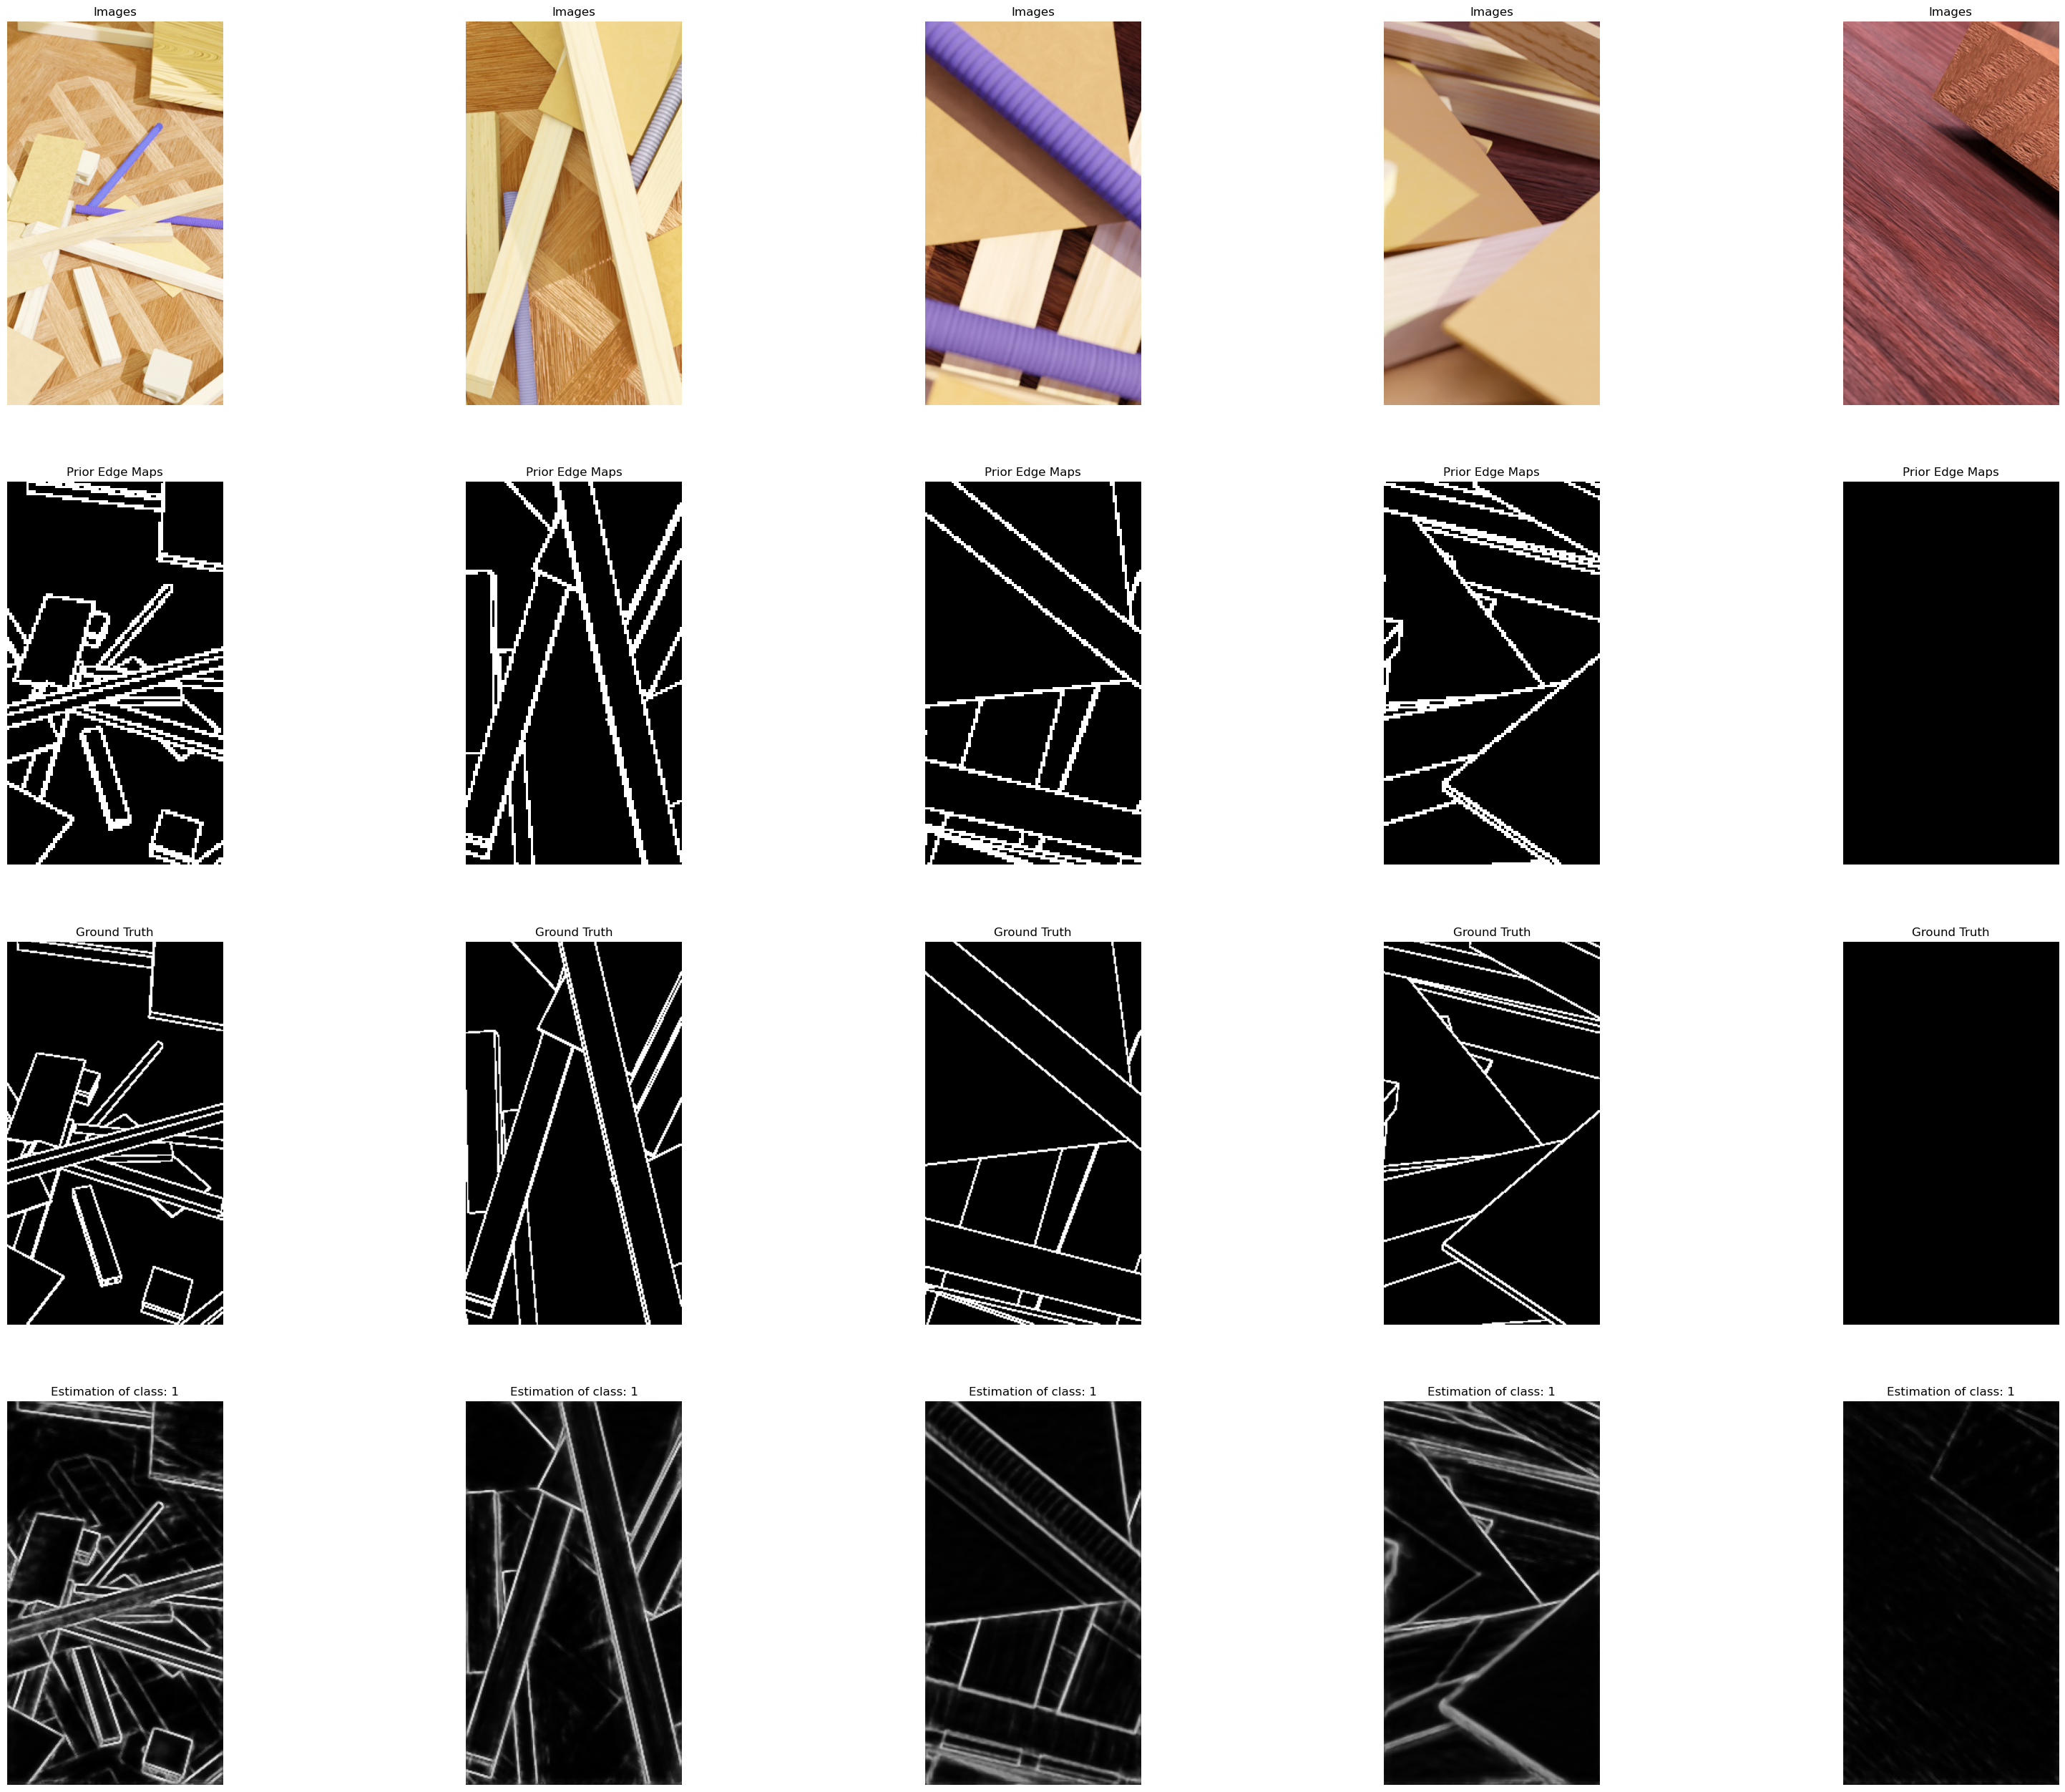

2022-12-12 22:56:45.817549: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [7]:
for inp, out in test_ds.take(1):
    pred = model.predict(inp)
    edge_detection_plots.plot_edges(images=inp['in_img'],
                                    prior = inp['in_edge'],
                                    labels=out['out_edge'],
                                    predictions=pred,
                                    batch_size=DataProcessing.cfg['TEST']['BATCH_SIZE'],
                                    num_classes=DataProcessing.num_classes['edge'])

Max Accuracy Score = 0.983 at 0.500
MF1 = 0.833
MF1_1 = 0.833, ODS_1 = 0.400


[0.4]

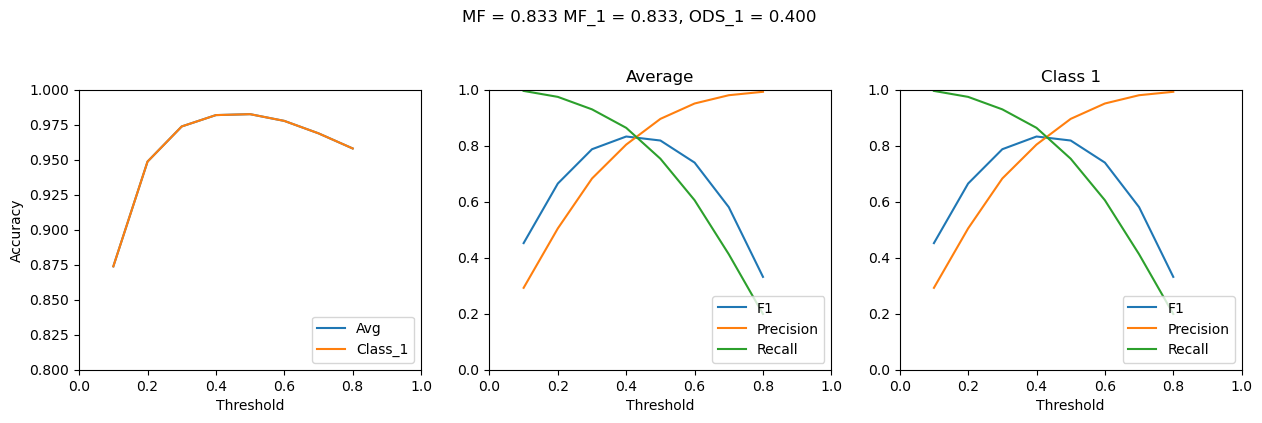

In [8]:
### Maximum F1 Score:
path_metrics_evaluation_plot = os.path.join(Model.Data.paths["FIGURES"],
                                            "threshold_metrics_evaluation_test_ds.svg")

edge_detection_plots.plot_threshold_metrics_evaluation(model=model, ds=test_ds,
                                                       num_classes=DataProcessing.num_classes['edge'],
                                                       classes_displayed_individually=True,
                                                       save=Model.cfg["SAVE"],
                                                       path=path_metrics_evaluation_plot,
                                                       accuracy_y_lim_min=0.8)


In [ ]:
if Model.cfg["CONVERT_TO_TFLITE"]:
    Model.convert_model_to_tflite(model)